### Required imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import pyphi # needs nonbinary install
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True
pyphi.config.WELCOME_OFF = True

from temporal_emergence import TPMMaker, CoarseGrainer, PhiCalculator, DataGenerator, Helpers


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



### Loading data for neurons 143, 168

In [2]:
times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

n_143 = good_neurons_probe1[143]
n_168 = good_neurons_probe1[168]

(371,)
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Get a nonbinary TPM for neurons 143, 168

In [3]:
neurons = [143,168]
cluster_143_168 = good_neurons_probe1[neurons]
#TPM = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,2000)

### Coarse grain it to get the macro

In [7]:
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
macro_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM[0], state_map, num_states_per_elem)

### Do this repeatedly for different samples of the 143,168 data to plot the difference in Phi values.

In [12]:
micro_phis = []
macro_phis = []
for _ in range(10):
    num_transitions = 2000
    TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,num_transitions)
    #np.savetxt("TPMs/micro_example_143_168.csv", TPM)
    micro_phis.append(PhiCalculator.get_micro_average_phi(TPM, verbose=False))
    macro_phis.append(PhiCalculator.get_macro_average_phi(TPM, verbose=False))
print(micro_phis, macro_phis)

                                                                [0.0046673125, 0.0025306874999999973, 0.005074750000000002, 0.006474000000000004, 0.005469312499999997, 0.006858500000000008, 0.0046015625, 0.006047750000000003, 0.005919000000000001, 0.005364375000000003] [0.0032237499999999975, 0.0021702499999999986, 0.0008585000000000051, 0.0, 0.0, 0.0007479999999999917, 0.0, 0.00039150000000000296, 0.0, 0.0007169999999999954]


([<matplotlib.axis.XTick at 0x1294c3e48>,
 <a list of 2 Text xticklabel objects>)

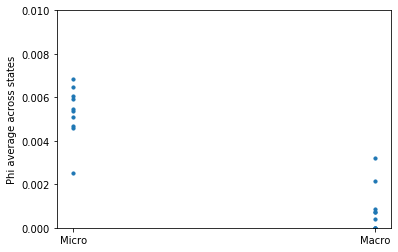

In [13]:
plt.scatter([1 for _ in range(10)] + [2 for _ in range(10)],[micro_phis,macro_phis],s=10)
plt.ylim([0,0.01])
plt.ylabel("Phi average across states")
plt.xticks([1,2],["Micro", "Macro"])

### Now analyse for varying parameters. Varying skip and varying size of micro bin.

In [4]:
NUM_BITS = 2

skips = list(range(2,11,2))

max_binsize = 0.02  # 50 ms bins
min_binsize = 0.001 # 1ms bins  -   probably won't work
num_binsizes = 10
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

num_transitions = 1000
micro_phis = np.zeros((len(binsizes), len(skips)))
macro_phis = np.zeros((len(binsizes), len(skips)))

for i in range(len(binsizes)):
    binsize = binsizes[i]
    for j in range(len(skips)):
        skip = skips[j]

        try:
            TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,binsize,NUM_BITS,skip,num_transitions)
            tpmname = "micro_143_168_bin_"+str(binsize)+"_skip_"+str(skip)+".csv" 
            np.savetxt("TPMs/"+tpmname, TPM)
            success = True
        except:
            success = False
            print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
        
        if success:
            micro_phis[i,j] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
            macro_phis[i,j] = PhiCalculator.get_macro_average_phi(TPM, verbose=False)
            print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
        
        else:
            micro_phis[i,j] = None
            macro_phis[i,j] = None


Failed for binsize: 0.001 and skip: 2
Failed for binsize: 0.001 and skip: 4
Failed for binsize: 0.001 and skip: 6
Failed for binsize: 0.001 and skip: 8
Failed for binsize: 0.001 and skip: 10
Success for binsize: 0.003111111111111111 and skip: 2
Success for binsize: 0.003111111111111111 and skip: 4
Success for binsize: 0.003111111111111111 and skip: 6
Success for binsize: 0.003111111111111111 and skip: 8
Success for binsize: 0.003111111111111111 and skip: 10
Success for binsize: 0.005222222222222222 and skip: 2
Success for binsize: 0.005222222222222222 and skip: 4
Success for binsize: 0.005222222222222222 and skip: 6
Success for binsize: 0.005222222222222222 and skip: 8
Success for binsize: 0.005222222222222222 and skip: 10
Success for binsize: 0.007333333333333333 and skip: 2
Success for binsize: 0.007333333333333333 and skip: 4
Success for binsize: 0.007333333333333333 and skip: 6
Success for binsize: 0.007333333333333333 and skip: 8
Success for binsize: 0.007333333333333333 and skip:

In [8]:
binsizes

array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])

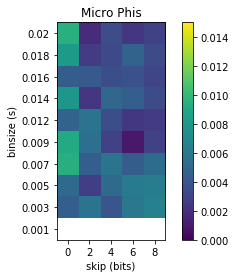

<Figure size 432x288 with 0 Axes>

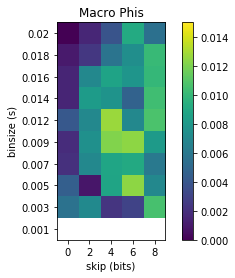

In [39]:
skips_corrected = [s - 2 for s in skips]

fig, ax = plt.subplots()

plt.imshow(micro_phis, vmin=0, vmax=0.015)
plt.title("Micro Phis")
plt.xlabel("skip (bits)")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize (s)")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()


plt.figure()
fig, ax = plt.subplots()

plt.imshow(macro_phis, vmin=0, vmax=0.015)
plt.title("Macro Phis")
plt.xlabel("skip (bits)")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize (s)")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()



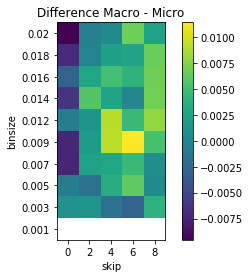

In [36]:
# and plot the difference
diff_macro_micro = macro_phis - micro_phis

fig, ax = plt.subplots()

plt.imshow(diff_macro_micro) #vmin=-0.015, vmax=0.015)
plt.title("Difference Macro - Micro")
plt.xlabel("skip")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()


In [42]:
pyphi.config.PROGRESS_BARS = False

In [45]:
# Same as above but many repetitions
NUM_BITS = 2
REPS = 20

skips = list(range(2,11,2))

max_binsize = 0.02  # 50 ms bins
min_binsize = 0.001 # 1ms bins  -   probably won't work
num_binsizes = 10
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

num_transitions = 1000
micro_phis_reps = np.zeros((len(binsizes), len(skips), REPS))
macro_phis_reps = np.zeros((len(binsizes), len(skips), REPS))

for rep in range(REPS):
    for i in range(len(binsizes)):
        binsize = binsizes[i]
        for j in range(len(skips)):
            skip = skips[j]

            try:
                TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,binsize,NUM_BITS,skip,num_transitions)
                tpmname = "micro_143_168_bin_"+str(binsize)+"_skip_"+str(skip)+str(rep)+".csv" 
                np.savetxt("TPMs/"+tpmname, TPM)
                success = True
            except:
                success = False
                print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            if success:
                micro_phis_reps[i,j, rep] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
                macro_phis_reps[i,j, rep] = PhiCalculator.get_macro_average_phi(TPM, verbose=False)
                print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            else:
                micro_phis_reps[i,j, rep] = None
                micro_phis_reps[i,j, rep] = None


Failed for binsize: 0.001 and skip: 2
Failed for binsize: 0.001 and skip: 4
Failed for binsize: 0.001 and skip: 6
Failed for binsize: 0.001 and skip: 8
Failed for binsize: 0.001 and skip: 10
Success for binsize: 0.003111111111111111 and skip: 2
Success for binsize: 0.003111111111111111 and skip: 4
Success for binsize: 0.003111111111111111 and skip: 6
Success for binsize: 0.003111111111111111 and skip: 8
Success for binsize: 0.003111111111111111 and skip: 10
Success for binsize: 0.005222222222222222 and skip: 2
Success for binsize: 0.005222222222222222 and skip: 4
Success for binsize: 0.005222222222222222 and skip: 6
Success for binsize: 0.005222222222222222 and skip: 8
Success for binsize: 0.005222222222222222 and skip: 10
Success for binsize: 0.007333333333333333 and skip: 2
Success for binsize: 0.007333333333333333 and skip: 4
Success for binsize: 0.007333333333333333 and skip: 6
Success for binsize: 0.007333333333333333 and skip: 8
Success for binsize: 0.007333333333333333 and skip:

KeyboardInterrupt: 